### 모델 훈련
#### 회귀 모델

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 정규방정식을 사용한 선형 회귀

#### 선형 회귀 모델의 예측(vector형태)

$\hat{\boldsymbol{y}} = \boldsymbol{h_{\theta}}({\boldsymbol{X}}) = \theta^T\cdot\boldsymbol{X}$

$\hat{\boldsymbol{y}}$은 예측값이다.

$\boldsymbol{X}$는 샘플의 특성 vector이다.  

$\boldsymbol{\theta}$는 편향값과 특성 가중치값들을 담고있는 모델의 파라미터 vector이다.

$\boldsymbol{h_{\theta}}$는 모델 파라미터 $\boldsymbol{\theta}$를 사용한 가설 (hypothesis)함수 이다.

In [10]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [11]:
var = np.random.rand(100, 1)
var.shape

(100, 1)

그림 저장: generated_data_plot


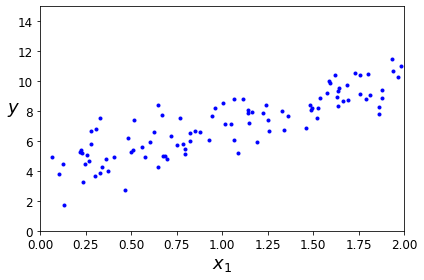

In [12]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

**정규 방정식**

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

In [13]:
# 모든 샘플에 x0 = 1 추가
X_b = np.c_[np.ones((100, 1)), X]  
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [14]:
theta_best

array([[3.89960932],
       [3.11452058]])

다음과 같이 예측값을 구하는 선형모델을 생성할 수 있다.

$\hat{y} = \mathbf{X} \boldsymbol{\hat{\theta}}$

In [15]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.89960932],
       [10.12865049]])

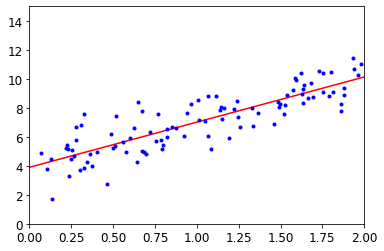

In [16]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [17]:
# sci-kit learn의 LinearRegression을 통해 훈련을 할 수 있다.

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.89960932]), array([[3.11452058]]))

In [18]:
lin_reg.predict(X_new)

array([[ 3.89960932],
       [10.12865049]])

In [19]:
# LinearRegression 클래스는 scipy.linalg.lstsq() 함수("least squares"의 약자)를 사용한다.
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.89960932],
       [3.11452058]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산합니다. $\mathbf{X}^{+}$는 $\mathbf{X}$의 _유사역행렬_ (pseudoinverse)입니다(Moore–Penrose 유사역행렬입니다). `np.linalg.pinv()`을 사용해서 유사역행렬을 직접 계산할 수 있습니다:

$\boldsymbol{\hat{\theta}} = \mathbf{X}^{-1}\hat{y}$

In [20]:
np.linalg.pinv(X_b).dot(y)

array([[3.89960932],
       [3.11452058]])

## 경사 하강법

경사 하강법은 여러 종류의 문제에서 최적의 solution을 찾는 방법중 하나 이다. 다양한 종류의 경사 하강법들이 있는데, 공통 목적은 비용 함수를 최소화 하기위해 반복해서 parameter를 조정해가는 것이다.

### 배치 경사 하강법을 사용한 선형 회귀

**비용 함수의 그레이디언트 벡터**

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

**경사 하강법의 스텝**

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$

배치경사 하강법은 매 스텝에서 전체 훈련 세트 X에 대해 계산한다. 그래서 매우 큰 훈련 세트에서는 아주 느리다.

In [21]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [22]:
theta

array([[3.89960932],
       [3.11452058]])

In [23]:
X_new_b.dot(theta)

array([[ 3.89960932],
       [10.12865049]])

In [24]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림 저장: gradient_descent_plot


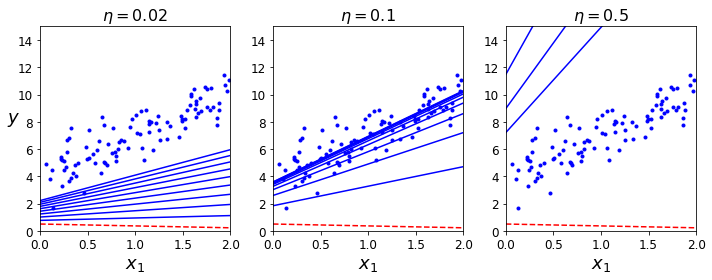

In [25]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

왼쪽은 학습률이 너무 낮아서 최적점에 도달하기까지 너무 시간이 오래걸리고, 오른쪽은 학습률이 너무 높아서 스텝마다 최적점에서 오히려 더 멀어진다. 

중간이 가장 적절한 학습률로 반복 몇번만에 최적점에 도달한다.

적절한 학습률을 찾기위해 GridSearch를 사용.
그러나 GridSearch에서 수렴하는데에 너무 오래걸리는 모델을 막기위해 반복횟수를 제한한다. 

반복횟수가 너무 작으면 최적점에 도달하기전에 알고리즘이 멈춤/ 너무 크면 시간 낭비함.

그래서 해결책은: 
1) 반복횟수를 넉넉하게 크게 지정하고, 
2) gradient vector가 아주 작아지면(vector의 norm이 어떤 값 $\boldsymbol{\epsilon}$ (허용 오차 tolerance)보다 작아지면 경사 하강법이 거의 최소값에 도달한것이므로 알고리즘을 중지한다.

### 확률적 경사 하강법

매 스텝에서 딱 한개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 gradient를 계산한다.

매 스텝 처리하는 데이터가 훨씬 작아지기때문에 알고리즘이 빠르다. (매우 큰 훈련 세트로도 훈련 가능)

In [27]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

그림 저장: sgd_plot


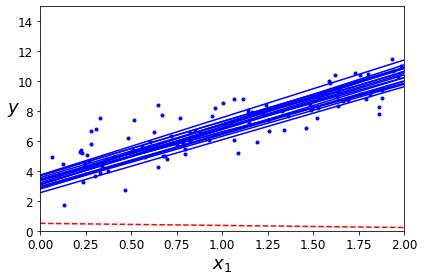

In [28]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)       
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
save_fig("sgd_plot")                                 
plt.show()                                          

In [29]:
theta

array([[3.9450112 ],
       [3.06841181]])

In [30]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [31]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.91214663]), array([3.152344]))

### 미니배치 경사 하강법

미니 배치라 부르는 임의의 작은 sample set에 대해 gradient를 계산한다. 미니 배치 경사하강법은 행렬 연산에 최적화된 hardware (GPU와 같은 HW)를 사용해서 향상된 성능을 활용할 수 있다.

미니배치는 최적점으로 converge하는 과정을 보면 SGD보다 덜 불규칙하게 움직인다. 결국 미니배치는 SGD보다 최소값에 더 가까이 도달하게 될것.

하지만 반면, 지역 최소값에서 빠져나오기 더 힘들어질수도 있다. (지역 최소값이 문제가 되는 경우)

In [32]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [33]:
theta

array([[3.80695726],
       [2.99644391]])

In [35]:
# 배치 경사하강법 (batch GD)
theta_path_bgd = np.array(theta_path_bgd)
# 확률적 경사하강법 (stochastic GD)
theta_path_sgd = np.array(theta_path_sgd)
# 미니배치 경사하강법 (mini batch GD)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


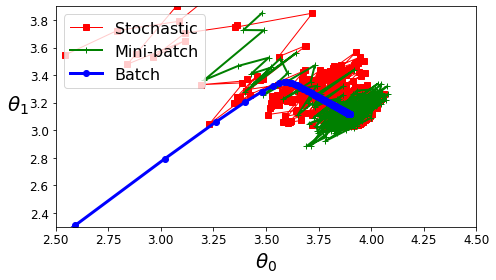

In [36]:
# 3 가지 경사하강법 하나의 plot에 그려서 비교

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

## 다항 회귀

분석하는 데이터가 단순한 직선보다 복잡한 형태라면? 

비선형 데이터를 학습하는데에도 선형모델을 사용할 수 있다.

polynomial regression = 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터 셋에 선형모델을 훈련시킨다. 

In [37]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [38]:
# 비선형 데이터 생성
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

그림 저장: quadratic_data_plot


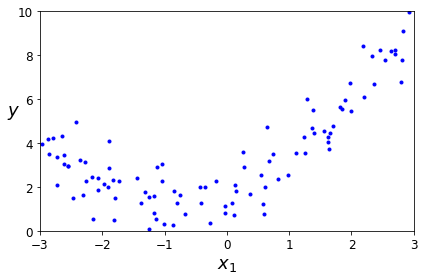

In [39]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [40]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [41]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [42]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

그림 저장: quadratic_predictions_plot


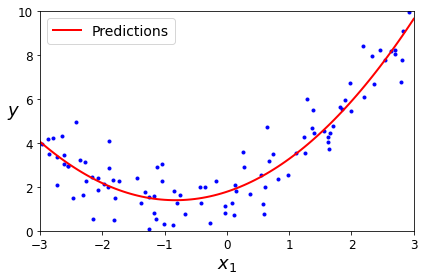

In [43]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

#### 학습곡선

그림 저장: high_degree_polynomials_plot


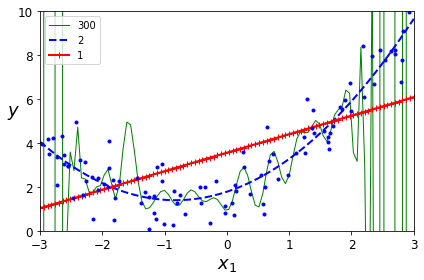

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 3가지 모델 - 선형, 2차, 300차 회귀 모델을 함께 그려 비교
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

이전에 보았던 교차검증 방식외에도 학습 곡선을 살펴보는 방법도 모델의 과대적합여부를 확인할 수 있는 방법이다.

학습곡선 - 훈련세트과 검증세트의 모델 성능을 훈련세트 크기의 함수로 나타낸다. 훈련세트에서 크기가 다른 서브 세트를 만들어서 모델을 여러번 훈련시킨다.

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

그림 저장: underfitting_learning_curves_plot


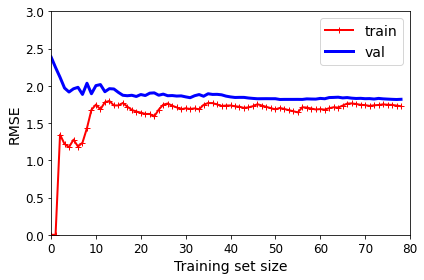

In [47]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         
save_fig("underfitting_learning_curves_plot")   
plt.show()   

그림 저장: learning_curves_plot


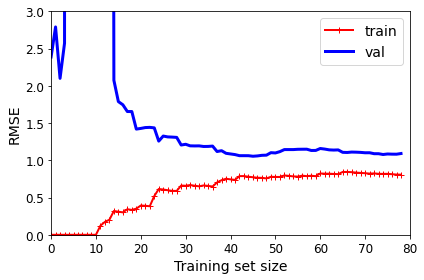

In [48]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           
save_fig("learning_curves_plot")  
plt.show()                        

## 규제가 있는 모델

**릿지 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2
$

In [49]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [50]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [51]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

그림 저장: ridge_regression_plot


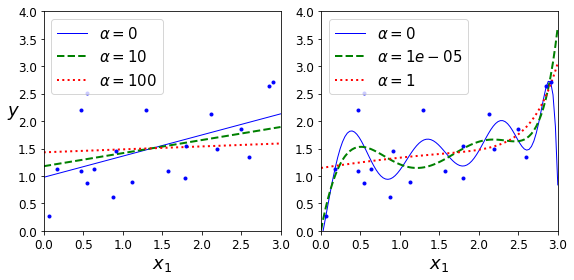

In [52]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

In [53]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

**라쏘 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  positive)


그림 저장: lasso_regression_plot


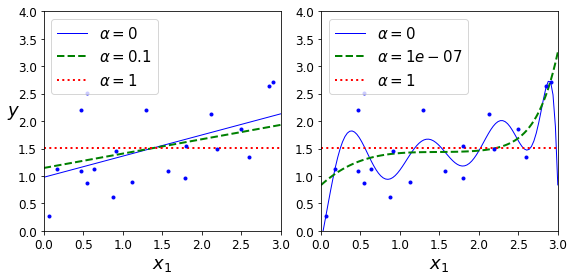

In [54]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [55]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

**엘라스틱넷 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$

In [56]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

In [57]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [58]:
# 조기 종료 예제

from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

그림 저장: early_stopping_plot


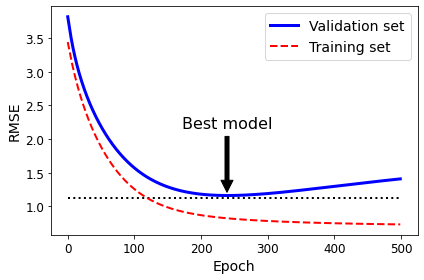

In [59]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

# plot annotation marking 생성
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [60]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
              warm_start=True))

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [62]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

그림 저장: lasso_vs_ridge_plot


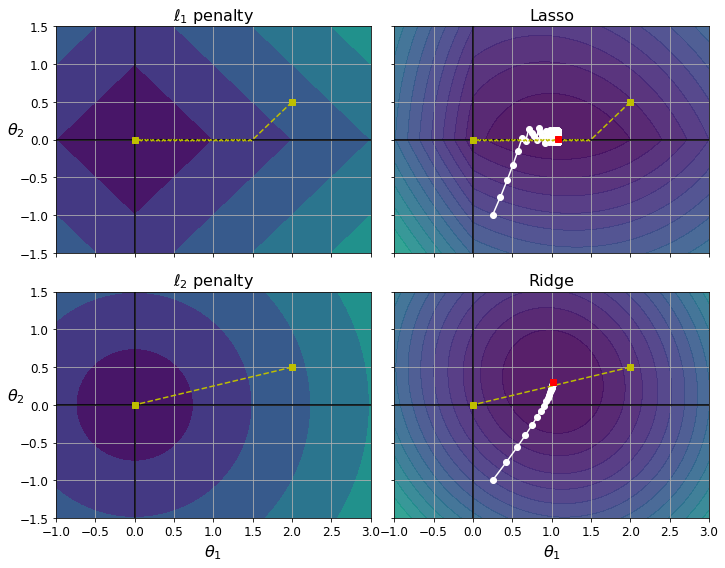

In [63]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()